In [131]:
import sys
sys.path.append('..')


import torch
from model import Model, restore
from dataset import ModisDataset, download_url
import matplotlib.pyplot as plt
import numpy as np
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pandas as pd
import sklearn.metrics
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def calc_dtw(true,pred):
    distances = list()
    for idx in range(true.shape[0]):
        dtw, path = fastdtw(true[idx], pred[idx], dist=euclidean)
        distances.append(dtw)
    return np.array(distances).mean()

def calc_metrics(true, pred):
    mae = sklearn.metrics.mean_absolute_error(true,pred)
    mse = sklearn.metrics.mean_squared_error(true,pred)
    r2 = sklearn.metrics.r2_score(true,pred)
    return mae, mse, r2


tumblack = "#000000"
tumblue = "#0065bd"
tumorange = "#e37222"
tumbluelight = "#64a0c8"
tumgray = "#999999"
tumlightgray = "#dad7cb"

import numpy as np
import pylab as pl
from numpy import fft

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz


/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


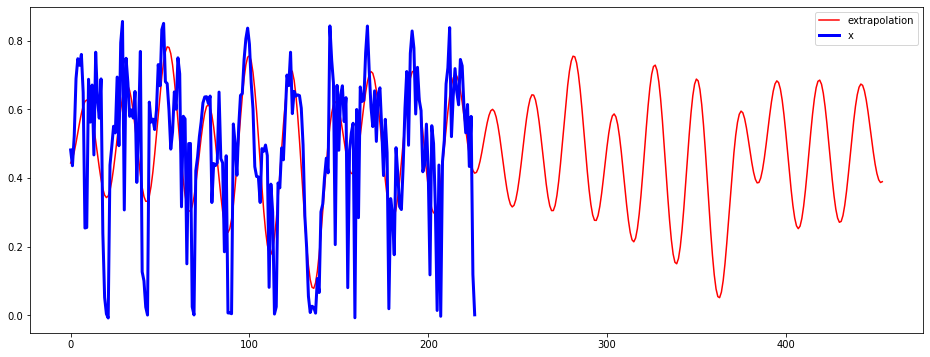

In [43]:

def fit_transform(x_fit, n_predict, n_harm):

    x = x_fit

    n = x.size                    # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies

    indexes = np.absolute(f).argsort()

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    extrapolation = restored_sig + p[0] * t

    pred = extrapolation[split_idx:]
    return pred, extrapolation


def plot(extrapolation, x):

    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
    ax.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
    ax.legend()



In [65]:
from tqdm.notebook import tqdm

def fit_dataset(data,n_harm, split_idx):

    true=list()
    pred=list()
    for idx in range(data.shape[0]):
        x_fit = data[idx,:split_idx,0]
        x_test = data[idx,split_idx: ,0]
        n_predict = x_test.shape[0]
        prediction, extrapolation = fit_transform(x_fit, n_predict, n_harm)
        true.append(x_test)
        pred.append(prediction)

    true = np.stack(true)
    pred = np.stack(pred)

    return true, pred

dataset = ModisDataset(region="germany",fold="validate", znormalize=False)
data = dataset.data
date = dataset.date

split_idx = np.where(dataset.date[0].astype(str) == "2010-01-01")[0][0]

metrics = list()
for n_harm in tqdm(range(300), total=300):
    true, pred =  fit_dataset(data, n_harm=n_harm, split_idx=split_idx)
    mae, mse, r2 = calc_metrics(true.reshape(-1), pred.reshape(-1))
    metrics.append([n_harm, mae, mse, r2])


local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz



MAE 0.1983, MSE 0.0740, R2 -0.3732


In [83]:
df = pd.DataFrame(metrics, columns=["n_harm","mae","mse","r2"]).set_index("n_harm")

,mae,mse,r2
n_harm,,,
0,0.168336,0.048574,0.098495
1,0.170404,0.049581,0.079804
2,0.170672,0.049719,0.077246
3,0.171686,0.050383,0.064916
12,0.174055,0.050811,0.056972


In [99]:
df.sort_values(by="mae", ascending=True).loc[:5]

,mae,mse,r2
n_harm,,,
0,0.168336,0.048574,0.098495
1,0.170404,0.049581,0.079804
2,0.170672,0.049719,0.077246
3,0.171686,0.050383,0.064916
4,0.173471,0.051529,0.043657
10,0.173932,0.050812,0.056967
12,0.174055,0.050811,0.056972
11,0.174240,0.050950,0.054406
13,0.174734,0.051523,0.043756


In [102]:
df.sort_values(by="mse", ascending=True).iloc[:5]

,mae,mse,r2
n_harm,,,
0,0.168336,0.048574,0.098495
1,0.170404,0.049581,0.079804
2,0.170672,0.049719,0.077246
3,0.171686,0.050383,0.064916
12,0.174055,0.050811,0.056972


In [103]:
df.sort_values(by="r2", ascending=False).iloc[:5]

,mae,mse,r2
n_harm,,,
0,0.168336,0.048574,0.098495
1,0.170404,0.049581,0.079804
2,0.170672,0.049719,0.077246
3,0.171686,0.050383,0.064916
12,0.174055,0.050811,0.056972


## Test Dataset Prediction

In [134]:
n_harm = 0

dataset = ModisDataset(region="germany",fold="test", znormalize=False)
testdata = dataset.data

true, pred = fit_dataset(testdata, n_harm=n_harm, split_idx=split_idx)

mae, mse, r2 = calc_metrics(true.reshape(-1), pred.reshape(-1))
dtw = calc_dtw(true, pred)
print(f"MAE {mae:.4f}, MSE {mse:.4f}, R2 {r2:.4f}, DTW {dtw:.4f}")

#fig,ax = plt.subplots()
#ax.plot(x)
#ax.plot(extrapolation)

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
MAE 0.1635, MSE 0.0470, R2 0.1172, DTW 37.5444


In [104]:
true

array([[-0.0294, -0.026 , -0.0113, ...,  0.7487,  0.6727,  0.7791],
       [ 0.0077,  0.0336,  0.114 , ...,  0.7811,  0.8166,  0.2879],
       [ 0.2073,  0.0283,  0.0267, ...,  0.5979,  0.5565,  0.7245],
       ...,
       [ 0.0341,  0.0277, -0.0067, ...,  0.6729,  0.7544,  0.7316],
       [-0.0172,  0.0133, -0.001 , ...,  0.7647,  0.8006,  0.6932],
       [-0.0185, -0.0257, -0.0068, ...,  0.507 ,  0.5633,  0.4012]])

In [105]:
pred

array([[0.5874717 , 0.6000717 , 0.6370717 , ..., 0.2468717 , 0.6828717 ,
        0.62334341],
       [0.77723531, 0.75773531, 0.78413531, ..., 0.86353531, 0.78893531,
        0.81187061],
       [0.35343135, 0.31213135, 0.26403135, ..., 0.40673135, 0.27913135,
        0.28346269],
       ...,
       [0.39284835, 0.52624835, 0.42234835, ..., 0.19764835, 0.12654835,
        0.47779669],
       [0.45196521, 0.54486521, 0.63236521, ..., 0.32176521, 0.51386521,
        0.45563041],
       [0.37314967, 0.31304967, 0.39564967, ..., 0.08824967, 0.50434967,
        0.35699935]])

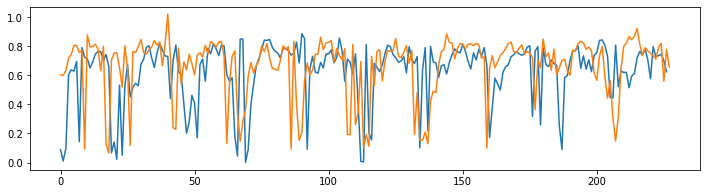

In [119]:
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(true[3,1:])
ax.plot(pred[3])

In [127]:
#!pip install fastdtw


24.559132619643673

In [124]:
path

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 1),
 (6, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 7),
 (7, 8),
 (7, 9),
 (7, 10),
 (7, 11),
 (7, 12),
 (7, 13),
 (7, 14),
 (7, 15),
 (7, 16),
 (7, 17),
 (8, 18),
 (8, 19),
 (8, 20),
 (8, 21),
 (8, 22),
 (8, 23),
 (8, 24),
 (9, 25),
 (9, 26),
 (9, 27),
 (9, 28),
 (9, 29),
 (10, 30),
 (11, 31),
 (11, 32),
 (12, 33),
 (13, 33),
 (14, 34),
 (15, 35),
 (16, 36),
 (16, 37),
 (16, 38),
 (17, 39),
 (18, 40),
 (19, 41),
 (20, 42),
 (21, 43),
 (22, 43),
 (23, 43),
 (24, 43),
 (25, 44),
 (26, 45),
 (27, 46),
 (28, 47),
 (29, 48),
 (30, 49),
 (31, 49),
 (32, 49),
 (33, 49),
 (34, 49),
 (35, 49),
 (36, 49),
 (37, 49),
 (38, 49),
 (39, 49),
 (40, 49),
 (41, 49),
 (42, 49),
 (43, 49),
 (44, 49),
 (45, 49),
 (46, 49),
 (47, 49),
 (48, 49),
 (49, 49),
 (50, 49),
 (51, 49),
 (52, 50),
 (53, 50),
 (54, 51),
 (55, 52),
 (56, 53),
 (57, 53),
 (58, 53),
 (59, 53),
 (60, 53),
 (61, 54),
 (62, 54),
 (63, 55),
 (63, 56),
 (63, 57),
 (63, 58),
 (63, 59),
 (6